Insert notebook description here

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import flopy
import sys
plt.rcParams['font.size'] = 14

In [2]:
bins_pth = os.path.join('..', 'bins') # Binaries

In [3]:
org_model_ws = os.path.join('..', 'hagfors_flopy_prep')
os.listdir(org_model_ws)

['hagfors.bhd',
 'hagfors.cbc',
 'hagfors.dis',
 'hagfors.dis.grb',
 'hagfors.dis_botm_layer1.txt',
 'hagfors.dis_botm_layer2.txt',
 'hagfors.dis_botm_layer3.txt',
 'hagfors.dis_delc.txt',
 'hagfors.dis_delr.txt',
 'hagfors.dis_idomain_layer1.txt',
 'hagfors.dis_idomain_layer2.txt',
 'hagfors.dis_idomain_layer3.txt',
 'hagfors.dis_top.txt',
 'hagfors.ghb',
 'hagfors.ghb_stress_period_data_1.txt',
 'hagfors.ic',
 'hagfors.ic_strt.txt',
 'hagfors.ims',
 'hagfors.lst',
 'hagfors.nam',
 'hagfors.npf',
 'hagfors.npf_angle1_layer1.txt',
 'hagfors.npf_angle1_layer2.txt',
 'hagfors.npf_angle1_layer3.txt',
 'hagfors.npf_angle2_layer1.txt',
 'hagfors.npf_angle2_layer2.txt',
 'hagfors.npf_angle2_layer3.txt',
 'hagfors.npf_angle3_layer1.txt',
 'hagfors.npf_angle3_layer2.txt',
 'hagfors.npf_angle3_layer3.txt',
 'hagfors.npf_icelltype_layer1.txt',
 'hagfors.npf_icelltype_layer2.txt',
 'hagfors.npf_icelltype_layer3.txt',
 'hagfors.npf_k22_layer1.txt',
 'hagfors.npf_k22_layer2.txt',
 'hagfors.npf_k22_

In [4]:
tmp_model_ws = os.path.join('..', 'temp_ss_pst_from') #Temporary SteadyState pstfrom model
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)

'..\\temp_ss_pst_from'

In [5]:
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_model_ws)
m = sim.get_model('hagfors')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package ghb...
    loading package sfr...
    loading package rch...
    loading package obs...
  loading ims package hagfors...


In [6]:
sr = pyemu.helpers.SpatialReference(
    delr = m.dis.delr.array,
    delc = m.dis.delc.array,
    xll = m.dis.xorigin.array,
    yll = m.dis.yorigin.array,
    rotation = m.dis.angrot.array,
    units = 'meters',
    epsg = 3006
)
sr

xul:426839.412; yul:6654846.416; rotation:45; proj4_str:+init=epsg:3006; units:meters; lenuni:2; length_multiplier:1.0

In [7]:
template_ws = os.path.join('..', 'hagfors_ss_template') # steadystate template
pf = pyemu.utils.PstFrom(
    original_d = tmp_model_ws, # where to find reference model
    new_d=template_ws, # where to build PEST
    remove_existing=True, # Stomp in new_d, if it exists
    longnames=True, # use PESTPP long paramter and observation names (handy storing metadata)
    spatial_reference=sr, # model spatial reference info
    zero_based=False, # model uses zero-based references
    start_datetime='17-06-2016' # model start time reference
)

2021-06-02 23:06:44.136712 starting: opening PstFrom.log for logging
2021-06-02 23:06:44.136712 starting PstFrom process
2021-06-02 23:06:44.141700 starting: setting up dirs
2021-06-02 23:06:44.142695 starting: removing existing new_d '..\hagfors_ss_template'
2021-06-02 23:06:44.166631 finished: removing existing new_d '..\hagfors_ss_template' took: 0:00:00.023936
2021-06-02 23:06:44.166631 starting: copying original_d '..\temp_ss_pst_from' to new_d '..\hagfors_ss_template'
2021-06-02 23:06:44.299276 finished: copying original_d '..\temp_ss_pst_from' to new_d '..\hagfors_ss_template' took: 0:00:00.132645
2021-06-02 23:06:44.301271 finished: setting up dirs took: 0:00:00.159571


Can't really motivate argument values. I'm sure they could be fine-tuned.

In [8]:
# the geostruct object for grid-scale parameters
grid_v = pyemu.geostats.ExpVario(contribution=1.0,a=8)
grid_gs = pyemu.geostats.GeoStruct(variograms=grid_v)

# the geostruct object for pilot-point-scale parameters
pp_v = pyemu.geostats.ExpVario(contribution=1.0, a=32)
pp_gs = pyemu.geostats.GeoStruct(variograms=pp_v)

# the geostruct for recharge grid-scale parameters
rch_v = pyemu.geostats.ExpVario(contribution=1.0, a=16)
rch_gs = pyemu.geostats.GeoStruct(variograms=rch_v)

spatial variogram, grid-scale


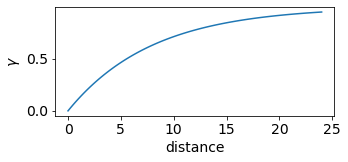

In [9]:
fig, ax = plt.subplots(1,1,figsize=(5,2))
grid_gs.plot(ax=ax)
print('spatial variogram, grid-scale')

In [10]:
# import flopy as part of the forward run process
pf.extra_py_imports.append('flopy')
# use the idomain array for masking parameter locations
ib = m.dis.idomain[0].array

In [11]:
# define a dict that contains file name tags and lower/upper bound information
tags = {"npf_k_":[0.1,10.],"npf_k33_":[.1,10],"rcha_recharge":[.5,1.5]}

This takes a while, and can probably be done a bit smarter:

In [12]:
# loop over each tag, bound info pair
for tag,bnd in tags.items():
    lb,ub = bnd[0],bnd[1]
    # find all array based files that have the tag in the name
    arr_files = [f for f in os.listdir(template_ws) if tag in f and f.endswith(".txt")]

    if len(arr_files) == 0:
        print("warning: no array files found for ",tag)
        continue
    
    # make sure each array file in nrow X ncol dimensions (not wrapped, sigh)
    for arr_file in arr_files:
        arr = np.loadtxt(os.path.join(template_ws,arr_file)).reshape(ib.shape)
        np.savetxt(os.path.join(template_ws,arr_file),arr,fmt="%15.6E")
        
    for arr_file in arr_files:
        pf.add_parameters(
            filenames=arr_file,
            par_type="grid",
            par_name_base=arr_file.split('.')[1]+"_gr",
            pargp=arr_file.split('.')[1]+"_gr",
            zone_array=ib,
            upper_bound=ub,
            lower_bound=lb,
            geostruct=grid_gs
        )
        pf.add_parameters(
            filenames=arr_file, 
            par_type="pilotpoints",
            par_name_base=arr_file.split('.')[1]+"_pp",
            pargp=arr_file.split('.')[1]+"_pp",
            zone_array=ib,
            upper_bound=ub,
            lower_bound=lb,
            pp_space=int(5 * 1), # 5 * redis_fac (=1 in example)
            geostruct=pp_gs
        )

2021-06-02 23:07:29.437887 starting: adding grid type multiplier style parameters for file(s) ['hagfors.npf_k_layer1.txt']
2021-06-02 23:07:29.439882 WARNING: 0) Inconsistency between geostruct transform and partrans.
2021-06-02 23:07:29.439882 WARNING: 1) Setting geostruct transform to log
2021-06-02 23:07:29.439882 WARNING: -) Better to pass an appropriately transformed geostruct
2021-06-02 23:07:29.439882 starting: loading array ..\hagfors_ss_template\hagfors.npf_k_layer1.txt
2021-06-02 23:07:29.487263 finished: loading array ..\hagfors_ss_template\hagfors.npf_k_layer1.txt took: 0:00:00.047381
2021-06-02 23:07:29.487263 loaded array '..\temp_ss_pst_from\hagfors.npf_k_layer1.txt' of shape (234, 380)
2021-06-02 23:07:29.574031 starting: writing array-based template file '..\hagfors_ss_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2021-06-02 23:07:29.575230 starting: writing template file ..\hagfors_ss_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0']
2021-06-02

2021-06-02 23:12:17.243303 starting: adding pilotpoints type multiplier style parameters for file(s) ['hagfors.npf_k_layer3.txt']
2021-06-02 23:12:17.243303 starting: loading array ..\hagfors_ss_template\hagfors.npf_k_layer3.txt
2021-06-02 23:12:17.333242 finished: loading array ..\hagfors_ss_template\hagfors.npf_k_layer3.txt took: 0:00:00.089939
2021-06-02 23:12:17.333242 loaded array '..\temp_ss_pst_from\hagfors.npf_k_layer3.txt' of shape (234, 380)
2021-06-02 23:12:17.473344 starting: writing array-based template file '..\hagfors_ss_template\npf_k_layer3_pp_inst0_pilotpoints.csv.tpl'
2021-06-02 23:12:17.473344 starting: setting up pilot point parameters
2021-06-02 23:12:17.473344 No spatial reference (containing cell spacing) passed.
2021-06-02 23:12:17.473344 OK - using spatial reference in parent object.
2021-06-02 23:12:22.537987 2602 pilot point parameters created
2021-06-02 23:12:22.537987 pilot point 'pargp':npf_k_layer3_pp_inst:0
2021-06-02 23:12:22.537987 finished: setting u

2021-06-02 23:12:39.263428 starting: writing template file ..\hagfors_ss_template\npf_k33_layer3_gr_inst0_grid.csv.tpl for ['npf_k33_layer3_gr_inst:0']
2021-06-02 23:12:39.263428 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries in index_cols.
2021-06-02 23:12:40.163319 finished: writing template file ..\hagfors_ss_template\npf_k33_layer3_gr_inst0_grid.csv.tpl for ['npf_k33_layer3_gr_inst:0'] took: 0:00:00.899891
2021-06-02 23:12:40.163319 finished: writing array-based template file '..\hagfors_ss_template\npf_k33_layer3_gr_inst0_grid.csv.tpl' took: 0:00:00.899891
2021-06-02 23:12:40.163319 saving zone array ..\hagfors_ss_template\npf_k33_layer3_gr_inst0_grid.csv.zone for tpl file ..\hagfors_ss_template\npf_k33_layer3_gr_inst0_grid.csv.tpl
2021-06-02 23:12:40.318094 finished: adding grid type multiplier style parameters for file(s) ['hagfors.npf_k33_layer3.txt'] took: 0:00:01.205006
2021-06-02 23:12:40.318094 starting: adding

In [13]:
# add grid-scale parameters for SFR reach conductance.  
# Use layer, row, col and reach number in the 
# parameter names
pf.add_parameters(
    filenames='hagfors.sfr_packagedata.txt', 
    par_name_base='sfr_rhk',
    pargp='sfr_rhk',
    index_cols=[0,1,2,3], 
    use_cols=[9],
    upper_bound=10.,
    lower_bound=0.1,
    ult_ubound=100.,
    ult_lbound=0.01,
    par_type='grid'
)

2021-06-02 23:13:30.182994 starting: adding grid type multiplier style parameters for file(s) ['hagfors.sfr_packagedata.txt']
2021-06-02 23:13:30.182994 starting: loading list ..\hagfors_ss_template\hagfors.sfr_packagedata.txt
2021-06-02 23:13:30.182994 starting: reading list ..\hagfors_ss_template\hagfors.sfr_packagedata.txt
2021-06-02 23:13:30.193355 finished: reading list ..\hagfors_ss_template\hagfors.sfr_packagedata.txt took: 0:00:00.010361
2021-06-02 23:13:30.203414 loaded list '..\hagfors_ss_template\hagfors.sfr_packagedata.txt' of shape (698, 15)
2021-06-02 23:13:30.213370 finished: loading list ..\hagfors_ss_template\hagfors.sfr_packagedata.txt took: 0:00:00.030376
2021-06-02 23:13:30.213370 starting: writing list-based template file '..\hagfors_ss_template\sfr_rhk_inst0_grid.csv.tpl'
2021-06-02 23:13:30.253277 finished: writing list-based template file '..\hagfors_ss_template\sfr_rhk_inst0_grid.csv.tpl' took: 0:00:00.039907
2021-06-02 23:13:30.263139 finished: adding grid typ

List all template files:

In [14]:
[f for f in os.listdir(template_ws) if f.endswith('.tpl')]

['npf_k33_layer1_gr_inst0_grid.csv.tpl',
 'npf_k33_layer1_pp_inst0pp.dat.tpl',
 'npf_k33_layer2_gr_inst0_grid.csv.tpl',
 'npf_k33_layer2_pp_inst0pp.dat.tpl',
 'npf_k33_layer3_gr_inst0_grid.csv.tpl',
 'npf_k33_layer3_pp_inst0pp.dat.tpl',
 'npf_k_layer1_gr_inst0_grid.csv.tpl',
 'npf_k_layer1_pp_inst0pp.dat.tpl',
 'npf_k_layer2_gr_inst0_grid.csv.tpl',
 'npf_k_layer2_pp_inst0pp.dat.tpl',
 'npf_k_layer3_gr_inst0_grid.csv.tpl',
 'npf_k_layer3_pp_inst0pp.dat.tpl',
 'rcha_recharge_1_gr_inst0_grid.csv.tpl',
 'rcha_recharge_1_pp_inst0pp.dat.tpl',
 'sfr_rhk_inst0_grid.csv.tpl']

## Observations
Lets only use heads in this example:

In [15]:
df = pd.read_csv(os.path.join(pf.new_d,"head.obs.csv"),index_col=0)

In [16]:
hds_df = pf.add_observations(
    "head.obs.csv",  # model output file to use 
    insfile="head.obs.csv.ins",  # optional, define name of PEST instruction file
    index_cols="time",  # column used to index observation/outputs
    use_cols=list(df.columns.values),  # columns to setup observations for (can be multiple)
    prefix="hds",  # observation name prefix
)

2021-06-02 23:16:04.997848 starting: adding observations from output file head.obs.csv
2021-06-02 23:16:04.997848 starting: adding observations from tabular output file '['head.obs.csv']'
2021-06-02 23:16:04.997848 starting: reading list ..\hagfors_ss_template\head.obs.csv
2021-06-02 23:16:05.006329 finished: reading list ..\hagfors_ss_template\head.obs.csv took: 0:00:00.008481
2021-06-02 23:16:05.006329 starting: building insfile for tabular output file head.obs.csv
2021-06-02 23:16:05.012918 finished: building insfile for tabular output file head.obs.csv took: 0:00:00.006589
2021-06-02 23:16:05.012918 starting: adding observation from instruction file '..\hagfors_ss_template\head.obs.csv.ins'
2021-06-02 23:16:05.027855 finished: adding observation from instruction file '..\hagfors_ss_template\head.obs.csv.ins' took: 0:00:00.014937
2021-06-02 23:16:05.027855 finished: adding observations from tabular output file '['head.obs.csv']' took: 0:00:00.030007


,obsnme,obsval,weight,obgnme
hds_usecol:b10-2_time:1.0,hds_usecol:b10-2_time:1.0,133.348922,1.0,hds_usecol:b10-2
hds_usecol:b10-4_time:1.0,hds_usecol:b10-4_time:1.0,133.352039,1.0,hds_usecol:b10-4
hds_usecol:b10-5_time:1.0,hds_usecol:b10-5_time:1.0,133.352545,1.0,hds_usecol:b10-5
hds_usecol:b12-1_time:1.0,hds_usecol:b12-1_time:1.0,138.025196,1.0,hds_usecol:b12-1
hds_usecol:b13-1_time:1.0,hds_usecol:b13-1_time:1.0,138.231971,1.0,hds_usecol:b13-1
...,...,...,...,...
hds_usecol:ni1802-1_time:1.0,hds_usecol:ni1802-1_time:1.0,133.929098,1.0,hds_usecol:ni1802-1
hds_usecol:ni1803-1_time:1.0,hds_usecol:ni1803-1_time:1.0,133.962771,1.0,hds_usecol:ni1803-1
hds_usecol:ni1803-3_time:1.0,hds_usecol:ni1803-3_time:1.0,133.967701,1.0,hds_usecol:ni1803-3
hds_usecol:ni1804-1_time:1.0,hds_usecol:ni1804-1_time:1.0,134.025095,1.0,hds_usecol:ni1804-1


`obsvals` are set to simulated outputs. This needs to be changed to field-measured counterparts (where applicable). All other obs (with no field-measured counterpart) should have a weight of 0. This is adjusted after calling `pf.build_pst()`

In [17]:
hds_df

,obsnme,obsval,weight,obgnme
hds_usecol:b10-2_time:1.0,hds_usecol:b10-2_time:1.0,133.348922,1.0,hds_usecol:b10-2
hds_usecol:b10-4_time:1.0,hds_usecol:b10-4_time:1.0,133.352039,1.0,hds_usecol:b10-4
hds_usecol:b10-5_time:1.0,hds_usecol:b10-5_time:1.0,133.352545,1.0,hds_usecol:b10-5
hds_usecol:b12-1_time:1.0,hds_usecol:b12-1_time:1.0,138.025196,1.0,hds_usecol:b12-1
hds_usecol:b13-1_time:1.0,hds_usecol:b13-1_time:1.0,138.231971,1.0,hds_usecol:b13-1
...,...,...,...,...
hds_usecol:ni1802-1_time:1.0,hds_usecol:ni1802-1_time:1.0,133.929098,1.0,hds_usecol:ni1802-1
hds_usecol:ni1803-1_time:1.0,hds_usecol:ni1803-1_time:1.0,133.962771,1.0,hds_usecol:ni1803-1
hds_usecol:ni1803-3_time:1.0,hds_usecol:ni1803-3_time:1.0,133.967701,1.0,hds_usecol:ni1803-3
hds_usecol:ni1804-1_time:1.0,hds_usecol:ni1804-1_time:1.0,134.025095,1.0,hds_usecol:ni1804-1


### Final bits
Copy mf6 and pestpp-ies binaries to template directory:

In [18]:
for binary in ['mf6.exe', 'pestpp-ies.exe']: # Can this be solved to include seamless Linux use?
    shutil.copy2(os.path.join('..', 'bins', binary), template_ws)

In [19]:
# add model run command (only run once!)
pf.mod_sys_cmds.append('mf6')

In [20]:
# build pest control file
pst = pf.build_pst('hagfors_ss.pst',version=2)

noptmax:0, npar_adj:476600, nnz_obs:144
2021-06-02 23:22:26.261863 forward_run line:pyemu.os_utils.run(r'mf6')



Time to adjust the observation settings:

In [30]:
obs = pst.observation_data
obs.loc[:,"weight"] = 0.0 # Set all weights to 0
pset = set(pst.obs_names)
display(obs)

,obsnme,obsval,weight,obgnme,usecol,time
hds_usecol:b10-2_time:1.0,hds_usecol:b10-2_time:1.0,133.348922,0.0,hds_usecol:b10-2,b10-2,1.0
hds_usecol:b10-4_time:1.0,hds_usecol:b10-4_time:1.0,133.352039,0.0,hds_usecol:b10-4,b10-4,1.0
hds_usecol:b10-5_time:1.0,hds_usecol:b10-5_time:1.0,133.352545,0.0,hds_usecol:b10-5,b10-5,1.0
hds_usecol:b12-1_time:1.0,hds_usecol:b12-1_time:1.0,138.025196,0.0,hds_usecol:b12-1,b12-1,1.0
hds_usecol:b13-1_time:1.0,hds_usecol:b13-1_time:1.0,138.231971,0.0,hds_usecol:b13-1,b13-1,1.0
...,...,...,...,...,...,...
hds_usecol:ni1802-1_time:1.0,hds_usecol:ni1802-1_time:1.0,133.929098,0.0,hds_usecol:ni1802-1,ni1802-1,1.0
hds_usecol:ni1803-1_time:1.0,hds_usecol:ni1803-1_time:1.0,133.962771,0.0,hds_usecol:ni1803-1,ni1803-1,1.0
hds_usecol:ni1803-3_time:1.0,hds_usecol:ni1803-3_time:1.0,133.967701,0.0,hds_usecol:ni1803-3,ni1803-3,1.0
hds_usecol:ni1804-1_time:1.0,hds_usecol:ni1804-1_time:1.0,134.025095,0.0,hds_usecol:ni1804-1,ni1804-1,1.0


Read in field-measured values:

In [26]:
df = pd.read_excel(os.path.join('..', 'data', 'observations', 'heads_june16_steadystate.xlsx'))
display(df)

,obs_name,point_x,point_y,layer,measured_head,hh_computed_head,hh_residual_head
0,NI1501-2,427363.305355,6.655085e+06,2,137.15,138.82,-1.67
1,NI1501-3,427363.305355,6.655085e+06,3,136.99,138.89,-1.90
2,NI1503-2,427449.771824,6.655194e+06,1,139.33,140.89,-1.56
3,NI1503-3,427449.771824,6.655194e+06,3,139.31,140.87,-1.56
4,NI1405-1,427471.152459,6.655034e+06,1,138.44,139.21,-0.77
5,NI1405-2,427471.152459,6.655034e+06,3,138.44,139.12,-0.68
6,NI1601-2,427409.623896,6.654967e+06,2,137.90,138.67,-0.77
7,NI1601-3,427409.623896,6.654967e+06,3,137.87,138.67,-0.80
8,NI1602-2,427348.775419,6.654929e+06,3,134.90,137.80,-2.90
9,B9-2,426918.374000,6.654803e+06,1,133.75,134.83,-1.08


Column `measured_head` is self-explanatory. Column `hh_computed_head` and `hh_residual_head` refer to the structurally complex model previously developed of the site in 2018. Let's make a pointless flex just to show that we can acquire better residuals (and for me to get better acquainted with PyEMU).  

Transform the dataframe so it can be used to assign `obsval` and `weight` to `pst.observation_data`:

In [27]:
df = df[['obs_name', 'measured_head']].T
df.columns = df.iloc[0]
df = df[1:]
df.insert(loc=0, column='time', value=1)
df.columns.name = None
df.set_index('time', inplace=True)
display(df)

,NI1501-2,NI1501-3,NI1503-2,NI1503-3,NI1405-1,NI1405-2,NI1601-2,NI1601-3,NI1602-2,B9-2
time,,,,,,,,,,
1,137.15,136.99,139.33,139.31,138.44,138.44,137.9,137.87,134.9,133.75


Overly complex way of constructing last part of the `obsnme`:

In [28]:
dt_str = df.index.map(lambda x: 'time:'+str(float(x))).values
dt_str

array(['time:1.0'], dtype=object)

In [31]:
for col in df.columns:
    obsnme = 'hds_usecol:'+col.lower()+"_"+dt_str # Do these really need to be this ugly?
    cset = set(obsnme)
    missing = cset - pset
    assert len(missing) == 0,missing
    obs.loc[obsnme,"obsval"] = df.loc[:,col].values
    obs.loc[obsnme,"weight"] = 1.0 # Assign a weight only to those obs that have field-measured counterparts
print(pst.nnz_obs)
pst.nnz_obs_groups

10


['hds_usecol:b9-2',
 'hds_usecol:ni1405-1',
 'hds_usecol:ni1405-2',
 'hds_usecol:ni1501-2',
 'hds_usecol:ni1501-3',
 'hds_usecol:ni1503-2',
 'hds_usecol:ni1503-3',
 'hds_usecol:ni1601-2',
 'hds_usecol:ni1601-3',
 'hds_usecol:ni1602-2']

These obs will be part in the history matching:

In [35]:
pst.observation_data.loc[pst.observation_data['weight'] > 0]

,obsnme,obsval,weight,obgnme,usecol,time
hds_usecol:b9-2_time:1.0,hds_usecol:b9-2_time:1.0,133.75,1.0,hds_usecol:b9-2,b9-2,1.0
hds_usecol:ni1405-1_time:1.0,hds_usecol:ni1405-1_time:1.0,138.44,1.0,hds_usecol:ni1405-1,ni1405-1,1.0
hds_usecol:ni1405-2_time:1.0,hds_usecol:ni1405-2_time:1.0,138.44,1.0,hds_usecol:ni1405-2,ni1405-2,1.0
hds_usecol:ni1501-2_time:1.0,hds_usecol:ni1501-2_time:1.0,137.15,1.0,hds_usecol:ni1501-2,ni1501-2,1.0
hds_usecol:ni1501-3_time:1.0,hds_usecol:ni1501-3_time:1.0,136.99,1.0,hds_usecol:ni1501-3,ni1501-3,1.0
hds_usecol:ni1503-2_time:1.0,hds_usecol:ni1503-2_time:1.0,139.33,1.0,hds_usecol:ni1503-2,ni1503-2,1.0
hds_usecol:ni1503-3_time:1.0,hds_usecol:ni1503-3_time:1.0,139.31,1.0,hds_usecol:ni1503-3,ni1503-3,1.0
hds_usecol:ni1601-2_time:1.0,hds_usecol:ni1601-2_time:1.0,137.9,1.0,hds_usecol:ni1601-2,ni1601-2,1.0
hds_usecol:ni1601-3_time:1.0,hds_usecol:ni1601-3_time:1.0,137.87,1.0,hds_usecol:ni1601-3,ni1601-3,1.0
hds_usecol:ni1602-2_time:1.0,hds_usecol:ni1602-2_time:1.0,134.9,1.0,hds_usecol:ni1602-2,ni1602-2,1.0


These obs will **not** be part of the history matching:

In [36]:
pst.observation_data.loc[pst.observation_data['weight'] == 0]

,obsnme,obsval,weight,obgnme,usecol,time
hds_usecol:b10-2_time:1.0,hds_usecol:b10-2_time:1.0,133.349,0.0,hds_usecol:b10-2,b10-2,1.0
hds_usecol:b10-4_time:1.0,hds_usecol:b10-4_time:1.0,133.352,0.0,hds_usecol:b10-4,b10-4,1.0
hds_usecol:b10-5_time:1.0,hds_usecol:b10-5_time:1.0,133.353,0.0,hds_usecol:b10-5,b10-5,1.0
hds_usecol:b12-1_time:1.0,hds_usecol:b12-1_time:1.0,138.025,0.0,hds_usecol:b12-1,b12-1,1.0
hds_usecol:b13-1_time:1.0,hds_usecol:b13-1_time:1.0,138.232,0.0,hds_usecol:b13-1,b13-1,1.0
...,...,...,...,...,...,...
hds_usecol:ni1802-1_time:1.0,hds_usecol:ni1802-1_time:1.0,133.929,0.0,hds_usecol:ni1802-1,ni1802-1,1.0
hds_usecol:ni1803-1_time:1.0,hds_usecol:ni1803-1_time:1.0,133.963,0.0,hds_usecol:ni1803-1,ni1803-1,1.0
hds_usecol:ni1803-3_time:1.0,hds_usecol:ni1803-3_time:1.0,133.968,0.0,hds_usecol:ni1803-3,ni1803-3,1.0
hds_usecol:ni1804-1_time:1.0,hds_usecol:ni1804-1_time:1.0,134.025,0.0,hds_usecol:ni1804-1,ni1804-1,1.0


Forward run script. Obviously some stuff TODO (add head-differences, head-stage differences, secondary model outcomes...):

In [38]:
_ = [print(line.rstrip()) for line in open(os.path.join(pf.new_d,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
import flopy
def main():

    try:
       os.remove(r'head.obs.csv')
    except Exception as e:
       print(r'error removing tmp file:head.obs.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')


if __name__ == '__main__':
    mp.freeze_support()
    main()



In [39]:
# write the control file
pst.write(os.path.join(pf.new_d, 'hagfors.pst'))

noptmax:0, npar_adj:476600, nnz_obs:10


In [40]:
# draw from the prior and save the ensemble in binary format
pe = pf.draw(50, use_specsim=True)
pe.to_binary(os.path.join(template_ws, "prior.jcb"))

2021-06-02 23:42:19.680877 starting: drawing realizations
2021-06-02 23:42:19.911260 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 412 X 412
2021-06-02 23:42:23.863955 starting: SpecSim: drawing 50 realization for group npf_k_layer1_gr__multiplier with 65384 pars, (log) variance 0.1111111111111111 (sill 0.1111111111111111)
SpecSim.initialize() summary: full_delx X full_dely: 412 X 412
2021-06-02 23:42:27.524451 finished: SpecSim: drawing 50 realization for group npf_k_layer1_gr__multiplier with 65384 pars, (log) variance 0.1111111111111111 (sill 0.1111111111111111) took: 0:00:03.660496
2021-06-02 23:42:27.699634 starting: SpecSim: drawing 50 realization for group npf_k_layer2_gr__multiplier with 65384 pars, (log) variance 0.1111111111111111 (sill 0.1111111111111111)
SpecSim.initialize() summary: full_delx X full_dely: 412 X 412
2021-06-02 23:42:30.649259 finished: SpecSim: drawing 50 realization for group npf_k_layer2_gr__multipl

return type uncaught, losing Ensemble type, returning DataFrame


,multiplier_npf_k_layer1_gr_inst:0_i:0_j:42_x:426900.22_y:6654905.81_zone:1,multiplier_npf_k_layer1_gr_inst:0_i:0_j:43_x:426901.64_y:6654907.23_zone:1,multiplier_npf_k_layer1_gr_inst:0_i:0_j:44_x:426903.05_y:6654908.64_zone:1,multiplier_npf_k_layer1_gr_inst:0_i:0_j:45_x:426904.47_y:6654910.06_zone:1,multiplier_npf_k_layer1_gr_inst:0_i:0_j:46_x:426905.88_y:6654911.47_zone:1
0,3.313132,2.495206,1.398996,0.856088,1.000549
1,0.538599,0.871768,0.837993,0.723140,0.421389
2,0.253189,0.365677,0.353708,0.191204,0.528293
3,3.581607,1.850074,2.126993,0.887547,0.766906
4,3.070901,7.323631,2.326127,3.809260,5.633100
5,3.368190,5.181291,2.064498,1.481092,0.767695
6,9.849187,3.362075,2.007323,3.046685,1.661292
7,1.493575,1.157790,0.638019,0.351085,0.310564
8,1.095211,0.655599,0.582282,0.804806,0.677501
9,0.198986,0.242646,0.247893,0.264391,0.301164


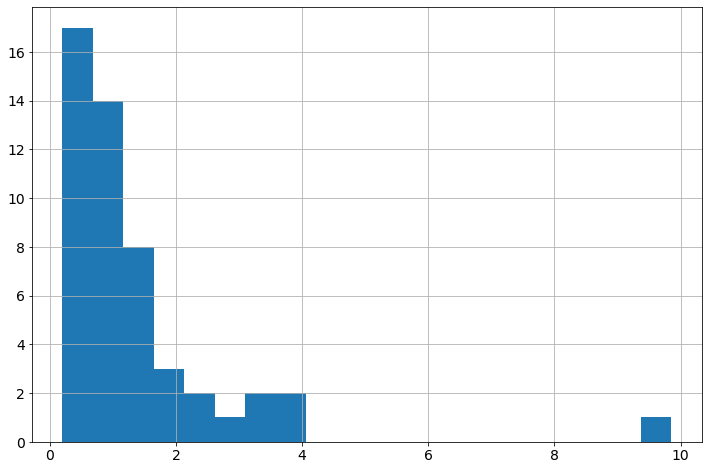

In [41]:
display(pe.loc[:,pst.adj_par_names[:5]])
fig, ax = plt.subplots(1,1, figsize=(12,8))
h = pe.loc[:,pst.adj_par_names[0]]._df.hist(bins=20)

In [42]:
# set some algorithmic controls
pst.control_data.noptmax = 0
pst.pestpp_options["additional_ins_delimiters"] = "," # Will fix Exception: run() returned non-zero: -1073740791

In [43]:
# write the control file
pst.write(os.path.join(pf.new_d, 'hagfors.pst'))

noptmax:0, npar_adj:476600, nnz_obs:10


In [44]:
# run with noptmax = 0
pyemu.os_utils.run("{0} hagfors.pst".format('pestpp-ies'), cwd=pf.new_d)

In [45]:
# make sure it ran
res_file = os.path.join(pf.new_d, 'hagfors.base.rei')
assert os.path.exists(res_file), res_file
pst.set_res(res_file)
print(pst.phi)

16.076302823151657


In [47]:
# Let's see if it can be reduced
pst.control_data.noptmax = 3

# define what file has the prior parameter ensemble
pst.pestpp_options['ies_par_en'] = 'prior.jcb'
pst.pestpp_options['ies_num_reals'] = 50  # enough?

# write the updated pest control file
pst.write(os.path.join(pf.new_d, 'hagfors.pst'),version=2)

noptmax:3, npar_adj:476600, nnz_obs:10


In [ ]:
pyemu.os_utils.start_workers(
    template_ws,
    'pestpp-ies',
    'hagfors.pst',
    num_workers=2,
    master_dir='../master_ss',
    worker_root='..'
)